In [7]:
%load_ext autoreload
%autoreload 2

from utils.build_utils import build_retro_iterator, build_forward_iterator, build_model, load_checkpoint
from models.model import ProjectNet
import argparse
import pandas as pd
import numpy as np
import json
import torch
import os
from tqdm import tqdm
from faerun import Faerun
import tmap as tm   
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import manifold
from scipy import stats
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Descriptors3D
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hierarchical contrastive learning

In [3]:
import json
with open("./data/uspto_1K_TPL_backward/template_supercalss_mapdict.json", "r") as f:
    map_dict = json.load(f)
map_dict

{'645': 2,
 '23': 6,
 '0': 2,
 '795': 2,
 '195': 1,
 '88': 6,
 '736': 2,
 '511': 5,
 '271': 2,
 '500': 8,
 '428': 6,
 '883': 3,
 '496': 1,
 '956': 3,
 '146': 2,
 '664': 3,
 '894': 1,
 '808': 1,
 '479': 2,
 '468': 1,
 '6': 2,
 '313': 9,
 '409': 6,
 '48': 6,
 '924': 4,
 '81': 9,
 '1': 7,
 '133': 2,
 '334': 2,
 '812': 2,
 '343': 7,
 '708': 6,
 '7': 6,
 '20': 6,
 '138': 1,
 '832': 9,
 '247': 6,
 '685': 2,
 '320': 2,
 '882': 2,
 '49': 1,
 '440': 3,
 '955': 3,
 '489': 7,
 '356': 7,
 '28': 7,
 '140': 1,
 '173': 10,
 '17': 2,
 '432': 9,
 '484': 1,
 '561': 6,
 '686': 5,
 '671': 3,
 '225': 7,
 '39': 9,
 '575': 6,
 '519': 1,
 '36': 1,
 '483': 1,
 '365': 2,
 '9': 2,
 '548': 2,
 '219': 2,
 '628': 7,
 '45': 2,
 '528': 1,
 '724': 2,
 '368': 2,
 '914': 0,
 '816': 2,
 '797': 2,
 '653': 1,
 '142': 8,
 '269': 7,
 '793': 6,
 '92': 7,
 '485': 1,
 '95': 1,
 '738': 2,
 '921': 1,
 '104': 2,
 '655': 6,
 '395': 2,
 '567': 1,
 '541': 1,
 '154': 1,
 '480': 2,
 '517': 2,
 '175': 7,
 '564': 1,
 '846': 1,
 '659': 3,

In [37]:
tsne = pd.read_csv("./result/tsne/tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])
tsne.head()

,x1,x2,labels,ids,superclass
0,0.593261,0.685719,366,0,4
1,0.046263,0.463037,47,1,2
2,0.780313,0.584189,212,10,9
3,0.514608,0.366219,297,100,2
4,0.772586,0.430301,122,1000,6


In [38]:
tsne = tsne.sort_values(by="ids").reset_index(drop=True)
tsne

,x1,x2,labels,ids,superclass
0,0.593261,0.685719,366,0,4
1,0.046263,0.463037,47,1,2
2,0.845752,0.184378,255,2,6
3,0.722399,0.079952,575,3,6
4,0.872682,0.656306,91,4,7
...,...,...,...,...,...
44506,0.815371,0.787597,1,44506,7
44507,0.477712,0.242847,146,44507,2
44508,0.592232,0.728745,96,44508,9
44509,0.906591,0.533488,142,44509,8


In [39]:
rxn = pd.read_csv("./data/uspto_1K_TPL_backward/raw_test.csv")
rxn

,idx,reactants>reagents>production,class,retro_template
0,360880,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]2[n:7][cH:8...,366,([C:1]-[c;H0;D3;+0:2]1:[n;H0;D2;+0:3]:[n;H0;D2...
1,3449,O[CH2:2][CH3:1].[OH:3][C:4](=[O:5])[c:6]1[cH:7...,47,([C;D1;H3:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:5]-[C:4...
2,40760,CC[O:32][C:30]([CH2:29][N:28]([C:26]([C:24]([c...,255,([C:3]-[C:2](=[O;D1;H0:4])-[OH;D1;+0:1].[C:7]-...
3,256297,CC(C)(C)OC(=O)[N:6]1[CH2:5][CH2:4][N:3]([C:2](...,575,([C:2]-[NH;D2;+0:1]-[C:3])>>(C-C(-C)(-C)-O-C(=...
4,19531,[CH3:1][C:2]1([CH3:3])[CH2:4][CH2:5][CH2:6][CH...,91,([C:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])>>([C...
...,...,...,...,...
44506,259178,O=[N+:1]([O-])[c:2]1[cH:3][cH:4][c:5]([F:6])[c...,1,([NH2;D1;+0:1]-[c:2])>>(O=[N+;H0;D3:1](-[O-])-...
44507,365838,O[C:5]([CH2:4][N:2]([CH3:1])[CH3:3])=[O:6].[NH...,146,([C:4]-[N;H0;D3;+0:5](-[C:6])-[C;H0;D3;+0:1](-...
44508,131932,O=S(Cl)[Cl:18].O[CH2:17][CH2:16][CH2:15][NH:14...,96,([C:3]-[CH2;D2;+0:2]-[Cl;H0;D1;+0:1])>>(Cl-S(=...
44509,146867,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,142,([C:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3])>>([C:1]-[C...


In [40]:
tsne = pd.concat([tsne, rxn], axis=1)
tsne

,x1,x2,labels,ids,superclass,idx,reactants>reagents>production,class,retro_template
0,0.593261,0.685719,366,0,4,360880,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]2[n:7][cH:8...,366,([C:1]-[c;H0;D3;+0:2]1:[n;H0;D2;+0:3]:[n;H0;D2...
1,0.046263,0.463037,47,1,2,3449,O[CH2:2][CH3:1].[OH:3][C:4](=[O:5])[c:6]1[cH:7...,47,([C;D1;H3:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:5]-[C:4...
2,0.845752,0.184378,255,2,6,40760,CC[O:32][C:30]([CH2:29][N:28]([C:26]([C:24]([c...,255,([C:3]-[C:2](=[O;D1;H0:4])-[OH;D1;+0:1].[C:7]-...
3,0.722399,0.079952,575,3,6,256297,CC(C)(C)OC(=O)[N:6]1[CH2:5][CH2:4][N:3]([C:2](...,575,([C:2]-[NH;D2;+0:1]-[C:3])>>(C-C(-C)(-C)-O-C(=...
4,0.872682,0.656306,91,4,7,19531,[CH3:1][C:2]1([CH3:3])[CH2:4][CH2:5][CH2:6][CH...,91,([C:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])>>([C...
...,...,...,...,...,...,...,...,...,...
44506,0.815371,0.787597,1,44506,7,259178,O=[N+:1]([O-])[c:2]1[cH:3][cH:4][c:5]([F:6])[c...,1,([NH2;D1;+0:1]-[c:2])>>(O=[N+;H0;D3:1](-[O-])-...
44507,0.477712,0.242847,146,44507,2,365838,O[C:5]([CH2:4][N:2]([CH3:1])[CH3:3])=[O:6].[NH...,146,([C:4]-[N;H0;D3;+0:5](-[C:6])-[C;H0;D3;+0:1](-...
44508,0.592232,0.728745,96,44508,9,131932,O=S(Cl)[Cl:18].O[CH2:17][CH2:16][CH2:15][NH:14...,96,([C:3]-[CH2;D2;+0:2]-[Cl;H0;D1;+0:1])>>(Cl-S(=...
44509,0.906591,0.533488,142,44509,8,146867,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,142,([C:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3])>>([C:1]-[C...


In [41]:
# tsne.to_csv("./result/tsne/hiclr_tsne_coord.csv", index=False)

<BarContainer object of 11 artists>

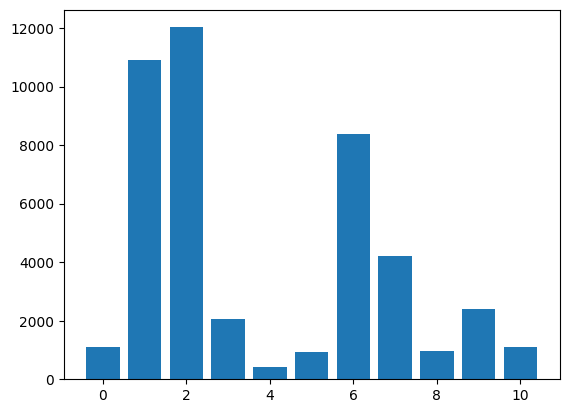

In [44]:
res = dict(Counter(tsne.superclass))
x = list(res.keys())
y = list(res.values())
plt.bar(x, y)

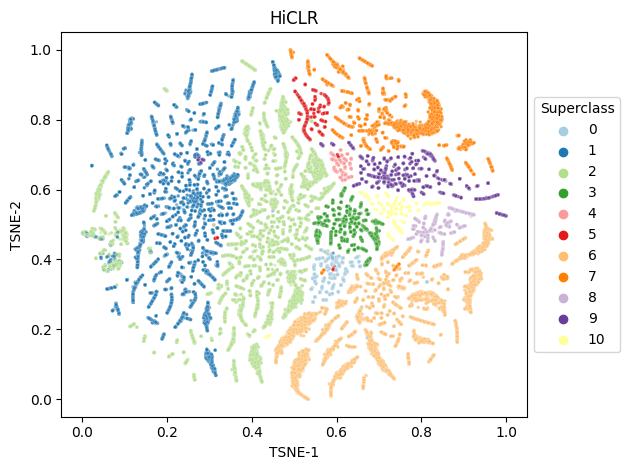

In [49]:
tsne = pd.read_csv("./result/tsne/hiclr_tsne_coord.csv")

fontsize = 10
plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("HiCLR")

plt.tight_layout()
# plt.savefig("./figures/tsne_hiclr.png", dpi=1000)

In [50]:
template_count = Counter(tsne.labels)
most_common = template_count.most_common(10)
most_common_label = [x[0] for x in most_common]
most_common_label

[1, 7, 88, 575, 247, 334, 146, 171, 230, 48]

In [51]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]

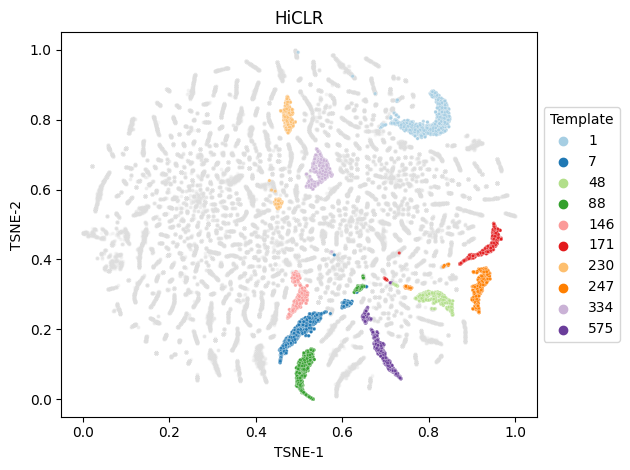

In [52]:
plt.figure()
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("HiCLR")
plt.tight_layout()
    
plt.savefig("./figures/tsne_hiclr_template.png", dpi=1000)
plt.show()

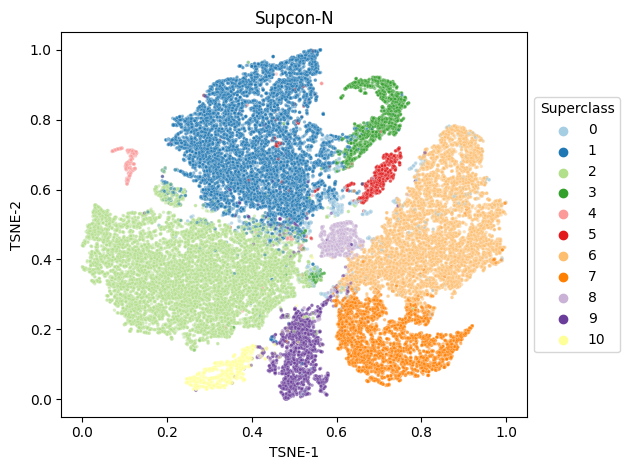

In [45]:
tsne = pd.read_csv("./result/tsne/supcon_superclass_tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])

plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("Supcon-N")

plt.tight_layout()

# plt.savefig("./figures/tsne_supcon_namerxn.png", dpi=1000)
plt.show()

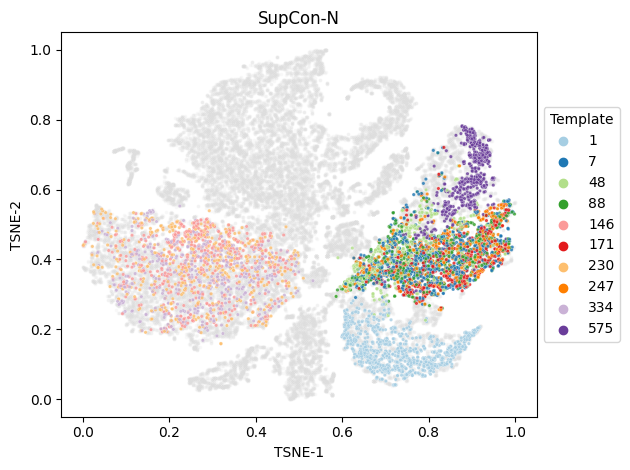

In [47]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]
plt.figure()
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SupCon-N")
plt.tight_layout()
    
plt.savefig("./figures/tsne_supcon_namerxn_template.png", dpi=1000)
plt.show()

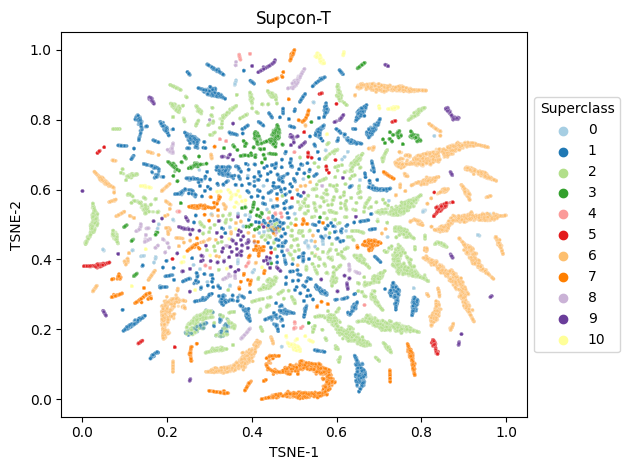

In [53]:
tsne = pd.read_csv("./result/tsne/supcon_template_tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])
plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("Supcon-T")

plt.tight_layout()

# plt.savefig("./figures/tsne_supcon_template.png", dpi=1000)
plt.show()

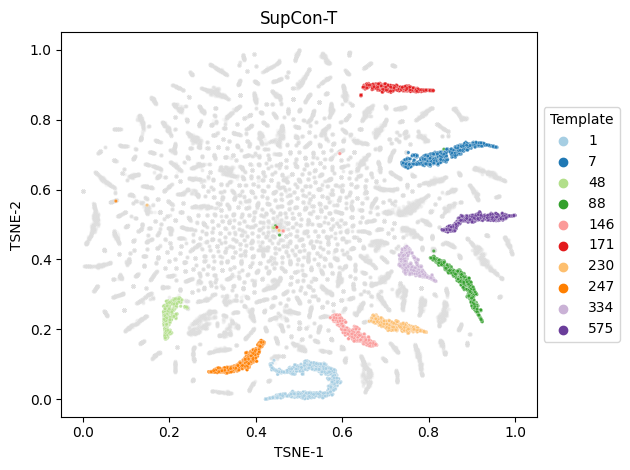

In [54]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]
plt.figure()
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SupCon-T")
plt.tight_layout()
    
plt.savefig("./figures/tsne_supcon_template_template.png", dpi=1000)
plt.show()

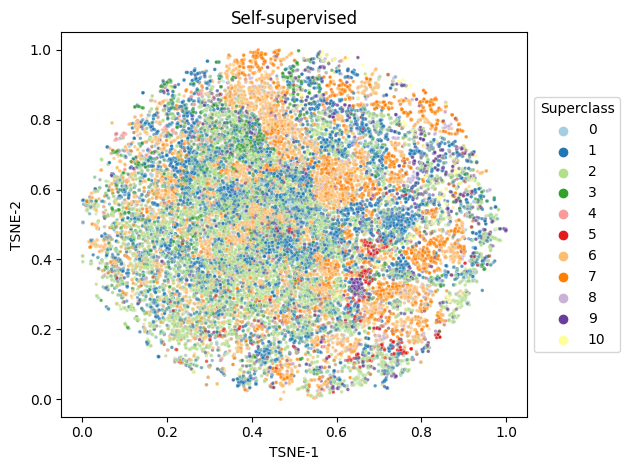

In [55]:
tsne = pd.read_csv("./result/tsne/selfsup_tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])
plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("Self-supervised")

plt.tight_layout()

# plt.savefig("./figures/tsne_selfsup.png", dpi=1000)
plt.show()

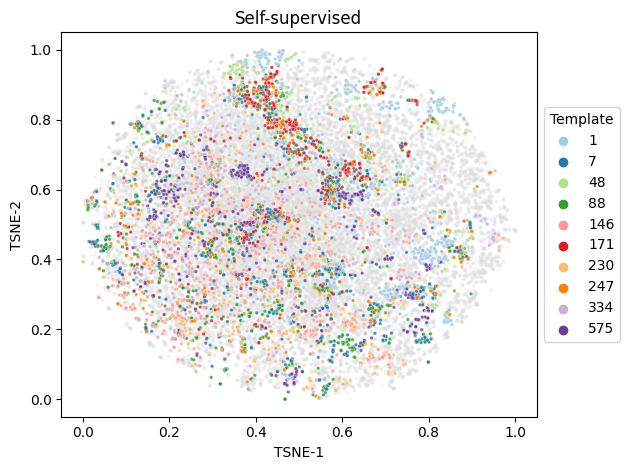

In [56]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]
plt.figure()
# plt.scatter(x=tsne["x1"], y=tsne["x2"], color="#B0A8B9", marker=".", s=8, alpha=0.5)
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], 
                hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("Self-supervised")
plt.tight_layout()
    
plt.savefig("./figures/tsne_selfsup_template.png", dpi=1000)
plt.show()

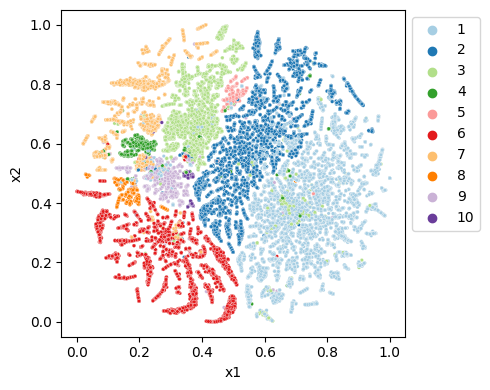

In [28]:
# visualize uspto50k
tsne = pd.read_csv("./result/tsne/50k_tsne_coord.csv")
plt.figure(figsize=(5,4))
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["labels"], s=6, palette="Paired")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=10)
plt.tight_layout()
# plt.savefig("./figures/50k_tsne.png", dpi=400)
plt.show()